In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(64,64)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=False, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [4]:
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

In [5]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]
        
        # Add a variable to store the alpha values
        self.alpha = None

    def random_op(self):
        # 무작위 시드 고정
        set_random_seed(42)  # 원하는 시드 값 설정
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
    
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        
        # Calculate alpha and store it in the instance variable
        self.alpha = torch.exp(-(Q_output - K_output)**2).transpose(0, 1)
        # Example usage:
        visualize_attention(self.alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        # print("Q_output size:", Q_output.size())
        # print("K_output size:", K_output.size())
        # print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(self.alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(self.alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 10)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [6]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# CIFAR-10 데이터 불러오기
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# 데이터 정규화 (0-255 값을 0-1 사이로)
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0

# RGB -> Grayscale 변환
# 공식: 0.299*R + 0.587*G + 0.114*B
X_train_gray = np.dot(X_train_full[...,:3], [0.299, 0.587, 0.114])
X_test_gray = np.dot(X_test_full[...,:3], [0.299, 0.587, 0.114])

# 정규화 (Grayscale로 변환 후 값이 0-1 사이에 있도록 다시 정규화)
X_train_gray = (X_train_gray - np.min(X_train_gray)) / (np.max(X_train_gray) - np.min(X_train_gray))
X_test_gray = (X_test_gray - np.min(X_test_gray)) / (np.max(X_test_gray) - np.min(X_test_gray))

# 원하는 두 개의 클래스만 선택 (예: 클래스 0과 1)
selected_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# 클래스 0과 1에 해당하는 데이터만 선택 (train set)
train_mask = np.isin(y_train_full, selected_classes)
X_train_filtered = X_train_gray[train_mask.squeeze()]
y_train_filtered = y_train_full[train_mask.squeeze()]

# # 클래스 0과 1에 해당하는 데이터만 선택 (test set)
# test_mask = np.isin(y_test_full, selected_classes)
# X_test_filtered = X_test_gray[test_mask.squeeze()]
# y_test_filtered = y_test_full[test_mask.squeeze()]


# 시드 고정
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 400
indices = np.random.choice(len(X_train_filtered), num_samples, replace=False)
X_sampled, y_sampled = X_train_filtered[indices], y_train_filtered[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, stratify=y_sampled, test_size=0.2, random_state=42
)

y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)


y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# 결과 출력
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Sampled train labels: {np.unique(y_train)}")
print(f"Sampled test labels: {np.unique(y_test)}")


2024-12-06 15:25:37.099930: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 15:25:37.115976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 15:25:37.134887: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 15:25:37.140643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 15:25:37.155313: I tensorflow/core/platform/cpu_feature_guar

Training set size: 320
Test set size: 80
Sampled train labels: [0. 1.]
Sampled test labels: [0. 1.]


In [7]:
X_train.shape

(320, 32, 32)

In [8]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [9]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [10]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_sampled, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0: 34, 1: 42, 2: 35, 3: 39, 4: 46, 5: 40, 6: 38, 7: 45, 8: 41, 9: 40}


In [11]:
# Model, optimizer, and criterion setup
model = QSANN_text_classifier(64, 4, 2, 1, 1)
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [12]:
# 학습 후 모델 파라미터 저장 경로
model_save_path = "/home/jaeyeob/QVT/result/CIFAR10/qsann_classifier_multi_10_20.pth"

In [13]:
# Create an instance of the new model with attention extraction
model = QSANN_text_classifier(64, 4, 2, 1, 1)
model.load_state_dict(torch.load(model_save_path))
model.eval()

/tmp/ipykernel_80155/3952207360.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


QSANN_text_classifier(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=10, bias=True)
)

In [14]:
# Print out the parameters and their shapes
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}")
        print(f"Shape: {param.shape}")
        print(f"Number of parameters: {param.numel()}")
        print("-" * 50)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Parameter name: Qnn.qnn.0.init_params_Q
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_K
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_V
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: final_layer.weight
Shape: torch.Size([10, 1024])
Number of parameters: 10240
--------------------------------------------------
Parameter name: final_layer.bias
Shape: torch.Size([10])
Number of parameters: 10
--------------------------------------------------
Total number of trainable parameters: 12554


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


torch.Size([2, 64, 16])
Row sums: [58.370842 54.935215 55.40802  54.143993 53.51338  55.01125  55.225082
 50.50589  56.648186 33.579536 42.67401  46.996437 56.673637 44.10036
 56.040775 57.87864  55.634148 57.22133  58.09466  53.623486 53.270775
 52.506897 53.050728 53.288124 50.99356  55.757996 53.122265 57.79701
 56.740204 54.09961  50.20662  56.540154 58.306824 58.385292 56.06467
 57.994263 57.76246  56.081554 56.55816  53.69104  55.374336 58.01705
 56.84449  57.292343 54.707336 51.90956  56.790688 58.082672 58.21808
 54.35406  46.67454  57.22554  58.40106  55.46531  41.755875 54.102577
 53.10475  37.321846 51.8882   47.029114 57.63226  55.397865 56.453434
 56.689476]


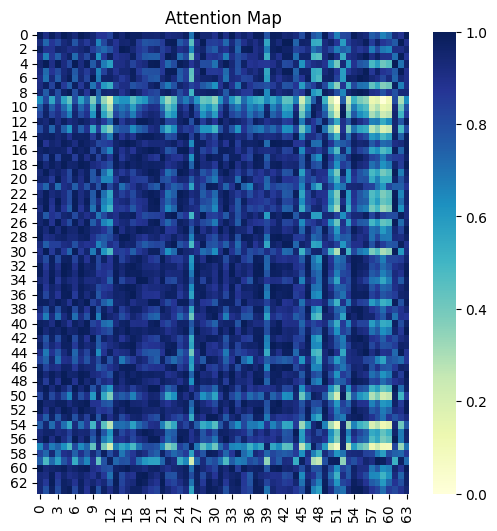

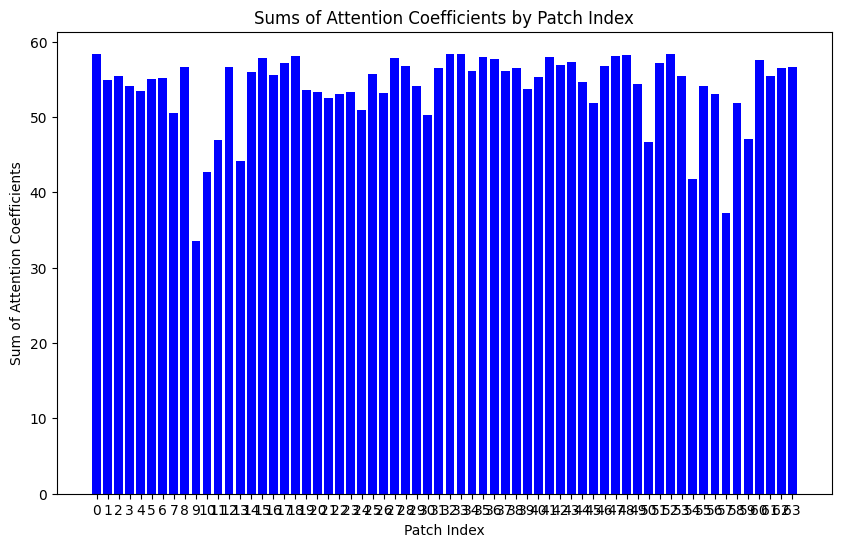

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    QSAL_pennylane-1               [-1, 64, 16]               0
   QSANN_pennylane-2               [-1, 64, 16]               0
            Linear-3                   [-1, 10]          10,250
Total params: 10,250
Trainable params: 10,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.04
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [15]:
from torchsummary import summary
summary(model, input_size=(64, 16))  # (sequence_length, embed_size)


In [16]:
def multi_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    pred_soft = torch.log_softmax(preds, dim=1)
    _, pred_index = torch.max(pred_soft, dim=1)
    print(pred_index)
    y = [int(w.argmax()) for w in y]
    y = torch.tensor(y, dtype=float)
    print(y)
    correct_pred = (pred_index == y).float()
    #round predictions to the closest integer
    
    acc = correct_pred.sum()/len(correct_pred)

    return acc

In [16]:
# for iepoch in tqdm(range(30)):
#     optimizer.zero_grad()
#     X_tensor=torch.tensor(X_train)
#     predictions=model(X_tensor.float()).squeeze(1)
#     #predictions=torch.sign(predictions)
#     #print(predictions)
#     label=torch.tensor(y_train)
#     #for i in range(len(label)):
#     #    if label[i]==1:
#     #        label[i] = 0
#     #    else:
#     #        label[i]=1
#     #print(label)
#     loss = criterion(predictions, label.float())
#     acc = multi_accuracy(predictions, label)
#     print('')
#     print('Accuracy:',acc)
#     print('')
#     print(loss)
#     loss.backward()
#     optimizer.step()
#     # Save the model parameters
#     torch.save(model.state_dict(), model_save_path)
#     print("Model parameters saved (epoch).")

# # Save the model parameters
# torch.save(model.state_dict(), model_save_path)
# print("Model parameters saved.")

torch.Size([80, 64, 16])
Row sums: [55.5337   55.66018  56.224335 53.354286 49.64972  54.869255 47.231277
 38.94988  51.82623  37.217075 41.883293 48.343803 45.3093   53.865982
 56.68883  56.921463 44.881607 57.45777  54.357857 42.84265  45.65497
 54.971703 46.751064 56.55902  40.301514 56.98195  52.41124  57.893356
 57.00352  55.835205 52.419243 57.7546   56.940384 56.86044  50.35955
 56.798145 56.737686 55.83622  52.909077 56.498856 43.45403  57.535534
 56.88736  57.640217 57.251083 54.63601  55.000042 51.99308  56.231033
 54.30265  46.725056 52.083416 56.30011  57.845993 49.409527 41.85433
 56.933826 38.051327 56.415905 52.906326 55.806614 53.168682 56.49408
 51.16179 ]


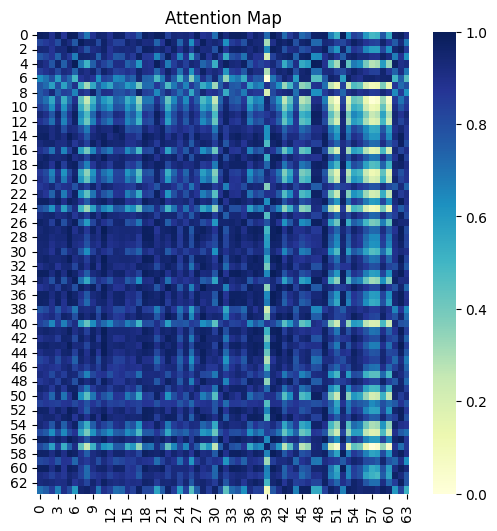

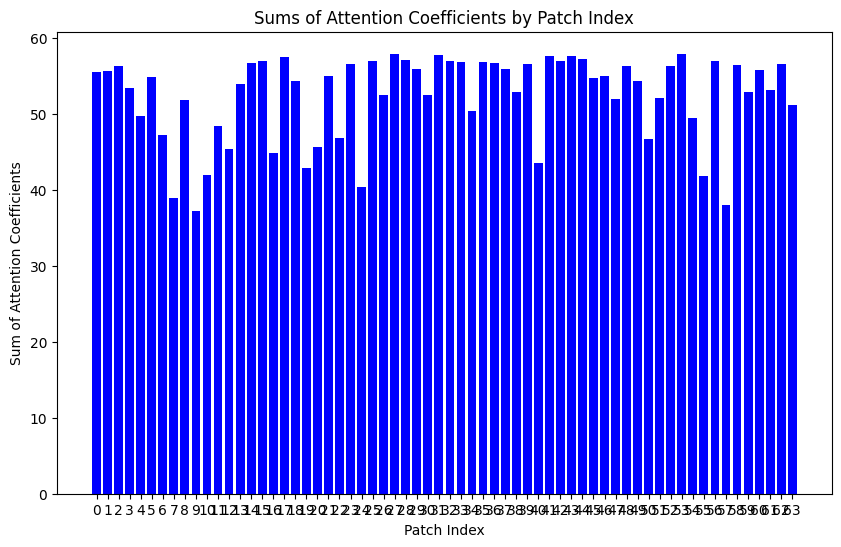

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1,
        4, 4, 4, 4, 4, 4, 4, 4])
tensor([9., 4., 3., 3., 4., 8., 6., 7., 2., 5., 2., 7., 8., 1., 6., 5., 4., 6.,
        1., 9., 5., 7., 0., 9., 0., 1., 9., 7., 0., 9., 7., 5., 6., 1., 1., 6.,
        7., 2., 5., 9., 5., 4., 3., 0., 4., 6., 4., 8., 2., 3., 9., 6., 2., 0.,
        4., 5., 4., 8., 1., 8., 3., 7., 2., 9., 7., 3., 1., 6., 2., 8., 4., 0.,
        3., 7., 1., 8., 3., 5., 8., 0.], dtype=torch.float64)

Accuracy: 0.125

AUROC: 0.6162846705422795

Precision (macro): 0.11153846153846154

Recall (macro): 0.1125

F1 Score (macro): 0.04291187739463601

AUPRC (macro): 0.2261219855168443



/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, average_precision_score

X_tensor=torch.tensor(X_test)
predictions=model(X_tensor.float()).squeeze(1)
label=torch.tensor(y_test)

loss = criterion(predictions, label.float())

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Get predicted classes
predicted_classes = np.argmax(preds_np, axis=1)

# Calculate Accuracy
acc = multi_accuracy(predictions, label.float())

# Calculate AUROC for each class (one-vs-rest approach)
auroc = roc_auc_score(labels_np, preds_np, multi_class="ovr")

# Ensure labels_np is in class label form, not one-hot encoded
if labels_np.ndim > 1:
    labels_np = np.argmax(labels_np, axis=1)


# Calculate Precision, Recall, and F1 Score (macro average for multi-class)
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, predicted_classes, average='macro')

# Calculate AUPRC (Area Under the Precision-Recall Curve) for each class
auprc = average_precision_score(labels_np, preds_np, average="macro")

# Print results
print(f'\nAccuracy: {acc}\n')
# print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision (macro): {precision}\n')
print(f'Recall (macro): {recall}\n')
print(f'F1 Score (macro): {f1}\n')
print(f'AUPRC (macro): {auprc}\n')

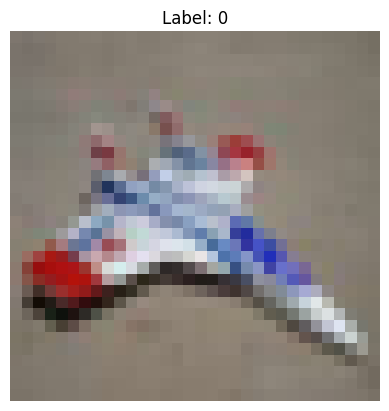

In [58]:
import tensorflow as tf
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 첫 번째 샘플 추출
image = train_images[30]

# 이미지 시각화
plt.imshow(image)
plt.title(f'Label: {train_labels[30][0]}')
plt.axis('off')
plt.show()


In [48]:
image_gray = np.dot(image[...,:3], [0.299, 0.587, 0.114])
single = np.array([split_into_non_overlapping_patches(image_gray)])

In [49]:
single

array([[[119.48 , 116.295, 120.181, ..., 117.181, 119.181, 120.252],
        [123.138, 123.138, 125.138, ..., 122.138, 125.725, 124.138],
        [123.138, 125.138, 127.138, ..., 127.725, 127.138, 128.138],
        ...,
        [127.622, 129.138, 130.138, ..., 126.252, 129.138, 129.138],
        [127.024, 127.269, 130.383, ..., 126.665, 124.665, 123.665],
        [112.383,  90.138, 106.024, ..., 120.551, 119.138, 114.138]]])

In [50]:
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

In [51]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [52]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(64, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

/tmp/ipykernel_37930/3411256959.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attention_model.load_state_dict(torch.load(model_save_path))


AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=10, bias=True)
)

Row sums: [60.645126 55.88585  58.66762  56.386497 60.761223 36.39501  59.996613
 60.704628 60.76712  60.500267 56.953636 59.361702 60.562714 60.59684
 31.337383 59.6286   58.491318 57.056007 60.422527 60.677464 59.918823
 60.617638 59.75159  57.84482  59.598392 53.83531  60.770702 56.271133
 60.018074 60.67565  47.167572 58.65921  58.330708 56.932045 60.67535
 57.923782 56.492794 58.903122 59.750786 60.65364  60.146572 49.679092
 60.132095 58.659447 59.270348 58.9478   50.623856 60.650406 56.33303
 60.44149  60.52501  60.008514 50.795296 46.954376 59.517845 51.118256
 59.87123  60.742718 45.893627 60.557243 60.751133 59.334183 60.456223
 60.76819 ]


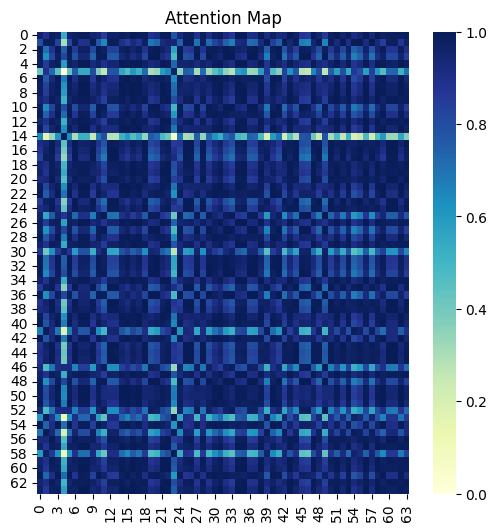

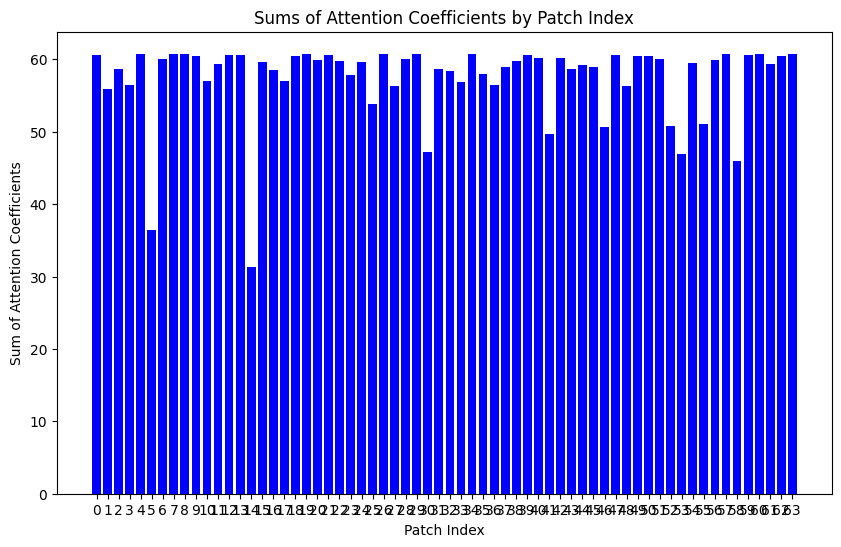

AxisError: axis 1 is out of bounds for array of dimension 1

In [53]:
# Make a prediction for the single sample
# Get the attention values for a single sample
with torch.no_grad():
    predictions = attention_model(single_sample).squeeze()
    # predicted_class = (torch.round(prediction)).item()
    # Get predicted classes
    preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
    predicted_classes = np.argmax(preds_np, axis=1)
    print(f"Predicted class for the sample: {predicted_classes}")

    _ = attention_model(single_sample)  # Forward pass to calculate attention
    attention_values = attention_model.attention_values  # Extracted attention values
    print(f"Extracted attention values: {attention_values}")

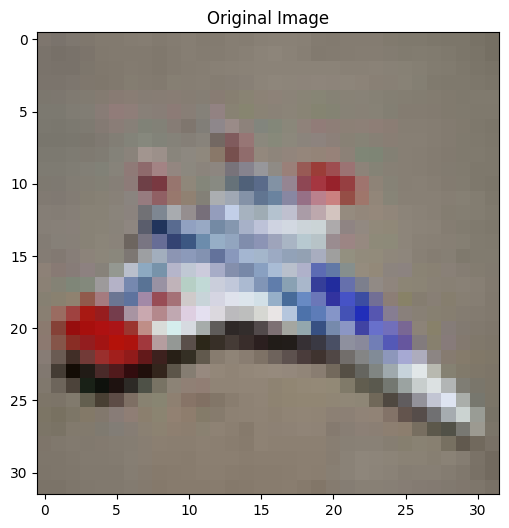

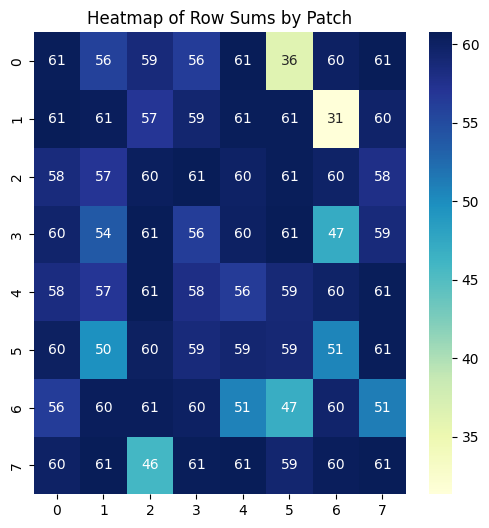

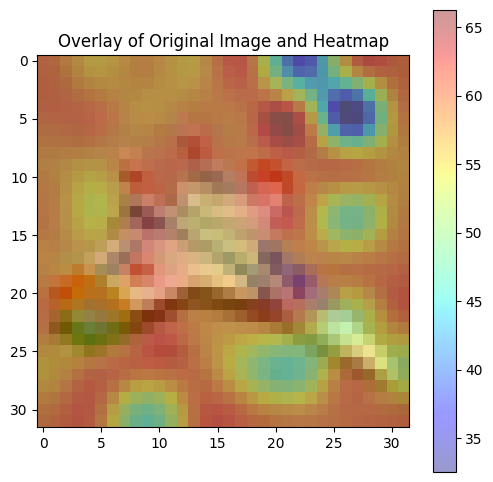

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, row_sums, patch_shape=(8, 8)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

    # 2. Create the heatmap using the row sums
    heatmap_values = np.array(row_sums).reshape(patch_shape)

    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_values, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Row Sums by Patch")
    plt.show()

    # 3. Resize the heatmap to match the sample size
    from scipy.ndimage import zoom
    resized_heatmap = zoom(heatmap_values, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(resized_heatmap, cmap='jet', alpha=0.4, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = image

# Example row sums based on output
row_sums =[60.645126, 55.88585, 58.66762, 56.386497, 60.761223, 36.39501, 59.996613, 60.704628, 60.76712, 60.500267, 56.953636, 59.361702, 60.562714, 60.59684, 31.337383, 59.6286, 58.491318, 57.056007, 60.422527, 60.677464, 59.918823, 60.617638, 59.75159, 57.84482, 59.598392, 53.83531, 60.770702, 56.271133, 60.018074, 60.67565, 47.167572, 58.65921, 58.330708, 56.932045, 60.67535, 57.923782, 56.492794, 58.903122, 59.750786, 60.65364, 60.146572, 49.679092, 60.132095, 58.659447, 59.270348, 58.9478, 50.623856, 60.650406, 56.33303, 60.44149, 60.52501, 60.008514, 50.795296, 46.954376, 59.517845, 51.118256, 59.87123, 60.742718, 45.893627, 60.557243, 60.751133, 59.334183, 60.456223, 60.76819]






# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image, row_sums, patch_shape=(8, 8))


-----------------------------------------